<a href="https://colab.research.google.com/github/gn96311/Geon_Repository/blob/master/Denoising_Program_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os, re, glob
import time
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageMath
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
import IPython.display as display

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
Dataset_dir = os.getcwd() + '/drive/My Drive/Colab/Data'

# Image to Patches

In [4]:
def image_to_patches(img_pad, stride_x, stride_y, mini_batch_size = 32):
    PATCH_SHAPE = (135, 135, 3)
    H, W, C = img_pad.shape
    batches = None

    num_patches_x = (W - PATCH_SHAPE[1]) / stride_x + 1
    num_patches_y = (H - PATCH_SHAPE[0]) / stride_y + 1

    total_patches = int(num_patches_x * num_patches_y)
    res = int(total_patches % mini_batch_size)

    batches = np.zeros((total_patches, *PATCH_SHAPE))

    x = y = 0
    for n in range(total_patches):
        patch = np.array([img_pad[y:y+PATCH_SHAPE[1], x:x+PATCH_SHAPE[0], :]])
        assert patch.shape == (1, *PATCH_SHAPE), "Shape mismatch, %s" % str(patch.shape)

        batches[n, :, :, :] = patch

        if x + PATCH_SHAPE[1] < W:
            x += stride_x

        elif x + PATCH_SHAPE[1] >= W and y + PATCH_SHAPE[0] < H:
            y += stride_y
            x = 0

        elif x + PATCH_SHAPE[1] >= W and y + PATCH_SHAPE[0] >= H:
            break

    if not res == 0:
        for i in range(mini_batch_size-res):
            batches = np.concatenate((batches, patch), axis=0)

    batches = batches.reshape(-1, mini_batch_size, PATCH_SHAPE[0], PATCH_SHAPE[1], PATCH_SHAPE[2])

    return batches, res

In [5]:
#img = Image.open(Dataset_dir + '/Mona.jpg')
#img = np.asarray(img)
#batches, res = image_to_patches(img, 135, 135)

# Save the patches into Folder

In [6]:
def save_img(input_image, height, width, image_number, mode="Noise"):
    image_number = ("{}".format(image_number)).zfill(3)
    figsize = (1, height/width) if height>=width else (width/height, 1)
    plt.figure(figsize=figsize)
    plt.imshow(input_image)
    plt.axis('off'), plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
    plt.savefig('{}/{}.jpg'.format(Dataset_dir + "/" + mode, image_number), bbox_inces = 'tight', pad_inches = 0, dpi = height)

In [7]:
class Dataset_maker():
    def __init__(self, img_list):
        self.images_list = img_list
        assert len(np.shape(self.images_list)) == 5, "The shape of Image list is not 5D, this shape is {}".format(len(np.shape(self.images_list)))
        
    def write_img(self):
        image_number = 0
        with tqdm(total = np.shape(self.images_list)[0] * (np.shape(self.images_list[0])[0]), desc = 'Loading') as pbar:
            for batch_number in range(np.shape(self.images_list)[0]):
                for images in self.images_list[batch_number]:
                    image_number += 1
                    clean_image = images/255.0
                    noise_image = clean_image + tf.random.poisson(clean_image.shape, 0.5)
                    save_img(clean_image, 135, 135, image_number, mode = 'Clean')
                    save_img(noise_image, 135, 135, image_number, mode = 'Noise')
                    pbar.update(1)

In [8]:
# dataset_make = Dataset_maker(batches)
# dataset_make.write_img()

# Image Show Functions

In [9]:
def noisy_imshow(image, ax=plt):
    image = np.asarray(image)
    image = (image + 0.5) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [10]:
def clean_imshow(image, ax=plt):
    image = np.asarray(image)
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [11]:
'''
x = train_set[0]
fig, axes = plt.subplots(ncols=2)
noisy_imshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
noisy_imshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')'''

"\nx = train_set[0]\nfig, axes = plt.subplots(ncols=2)\nnoisy_imshow(x[0], ax=axes[0])\naxes[0].set_title('Noisy')\nnoisy_imshow(x[1], ax=axes[1])\naxes[1].set_title('Clean')\nprint(f'image size is {x[0].shape}.')"

# Data Load Class

In [12]:
class Data_Loader():
    def __init__(self, root_dir, batch_size, data_mode, mode):
        self.batch_size = batch_size
        self.mode = mode
        self.root_dir = root_dir
        self.data_mode = data_mode

    def return_image_RGB(self, noise_path, clean_path):
        noise_img = tf.io.decode_image(tf.io.read_file(noise_path))
        noise_img = tf.cast(noise_img, tf.float32) / 255.0
        clean_img = tf.io.decode_image(tf.io.read_file(clean_path))
        clean_img = tf.cast(clean_img,tf.float32) / 255.0
        if self.data_mode == 'R':
            return noise_img[:,:, 0], clean_img[:,:,0]
        elif self.data_mode == 'G':
            return noise_img[:,:, 1], clean_img[:,:,1]
        elif self.data_mode == 'B':
            return noise_img[:,:, 2], clean_img[:,:,2]

    def return_test_image_RGB(self, noise_path, clean_path):
        noise_img = tf.io.decode_image(tf.io.read_file(noise_path))
        noise_img = tf.cast(noise_img, tf.float32) / 255.0
        clean_img = tf.io.decode_image(tf.io.read_file(clean_path))
        clean_img = tf.cast(clean_img,tf.float32) / 255.0
        if self.data_mode == 'R':
            return noise_img[:,:, 0], clean_img[:,:,0]
        elif self.data_mode == 'G':
            return noise_img[:,:, 1], clean_img[:,:,1]
        elif self.data_mode == 'B':
            return noise_img[:,:, 2], clean_img[:,:,2]
    
    def Make_Dataset(self):
        xy_list = ['Noise', 'Clean']
        if self.mode == 'train':
            for path in xy_list:
                if path == 'Noise':
                    noise_dir = os.path.join(self.root_dir, self.mode, path)
                    noise_train_path = sorted(glob(noise_dir + '/*.jpg'))
                elif path == 'Clean':
                    clean_dir = os.path.join(self.root_dir, self.mode, path)
                    clean_train_path = sorted(glob(clean_dir + '/*.jpg'))
            if self.data_mode == 'R':
                dataset = tf.data.Dataset.from_tensor_slices((noise_train_path, clean_train_path))
            elif self.data_mode == 'G':
                dataset = tf.data.Dataset.from_tensor_slices((noise_train_path, clean_train_path))
            elif self.data_mode == 'B':
                dataset = tf.data.Dataset.from_tensor_slices((noise_train_path, clean_train_path))
            dataset = dataset.map(self.return_image_RGB)
            dataset = dataset.batch(self.batch_size)
            dataset = dataset.shuffle(buffer_size = len(noise_train_path))

        elif self.mode == 'test':
            for path in xy_list:
                if path == 'Noise':
                    noise_dir = os.path.join(self.root_dir, self.mode, path)
                    noise_test_path = sorted(glob(noise_dir + '/*.jpg'))
                elif path == 'Clean':
                    clean_dir = os.path.join(self.root_dir, self.mode, path)
                    clean_test_path = sorted(glob(clean_dir + '/*.jpg'))
            if self.data_mode == 'R':
                dataset = tf.data.Dataset.from_tensor_slices((noise_test_path, clean_test_path))
            elif self.data_mode == 'G':
                dataset = tf.data.Dataset.from_tensor_slices((noise_test_path, clean_test_path))
            elif self.data_mode == 'B':
                dataset = tf.data.Dataset.from_tensor_slices((noise_test_path, clean_test_path))
            dataset = dataset.map(self.return_test_image_RGB)
            dataset = dataset.batch(self.batch_size)
        
        return dataset

In [13]:
Generate_train_ds_R = Data_Loader('/content/drive/My Drive/Colab/Data/', 4, data_mode = 'R', mode = 'train')
Generate_train_ds_G = Data_Loader('/content/drive/My Drive/Colab/Data/', 4, data_mode = 'G', mode = 'train')
Generate_train_ds_B = Data_Loader('/content/drive/My Drive/Colab/Data/', 4, data_mode = 'B', mode = 'train')
data_R = Generate_train_ds_R.Make_Dataset()
data_G = Generate_train_ds_G.Make_Dataset()
data_B = Generate_train_ds_B.Make_Dataset()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [14]:
Generate_test_ds_R = Data_Loader('/content/drive/My Drive/Colab/Data/', 4, data_mode = 'R', mode = 'test')
Generate_test_ds_G = Data_Loader('/content/drive/My Drive/Colab/Data/', 4, data_mode = 'G', mode = 'test')
Generate_test_ds_B = Data_Loader('/content/drive/My Drive/Colab/Data/', 4, data_mode = 'B', mode = 'test')
test_data_R = Generate_test_ds_R.Make_Dataset()
test_data_G = Generate_test_ds_G.Make_Dataset()
test_data_B = Generate_test_ds_B.Make_Dataset()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


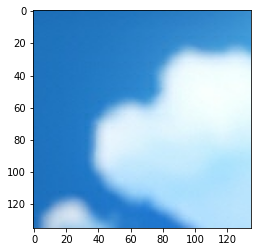

In [15]:
nn, cc = next(iter(test_data_R))
n1, c1 = next(iter(test_data_G))
n2, c2 = next(iter(test_data_B))
plt.imshow(c2[0])
plt.imshow(tf.stack([cc[0], c1[0], c2[0]], axis = 2))

In [16]:
#data_y[0]: noise/clean
#data_y[0][:]: batch

In [17]:
class input_conv_layer(tf.keras.layers.Layer):
    def __init__(self):
        super(input_conv_layer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, (3,3), padding = 'same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        
    def call(self, x, training=False, mask=None):
        return self.relu(self.conv(x))

In [18]:
class skip_layer(tf.keras.layers.Layer):
    def __init__(self):
        super(skip_layer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(3, (3,3), padding = 'same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
    
    def call(self, x, training = False, mask=None):
        return self.relu(self.conv(x))

In [19]:
class Multi_LSTM_first(tf.keras.layers.Layer):
    def __init__(self):
        super(Multi_LSTM, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same')
        self.conv2 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same')
        self.convlstm1 = tf.keras.layers.ConvLSTM2D(8, (1, 15), padding = 'same')
        self.convlstm2 = tf.keras.layers.ConvLSTM2D(8, (1, 15), padding = 'same')
        self.convlstm3 = tf.keras.layers.ConvLSTM2D(8, (1, 15), padding = 'same')
        self.convlstm4 = tf.keras.layers.ConvLSTM2D(8, (1, 15), padding = 'same')
        
        
    def call(self, x, training = False, mask = None):
        rot_0 = self.conv2(tf.expand_dims(x, axis=1))
        rot_90 = self.conv2(tf.expand_dims(tf.image.rot90(x, k=1), axis=1))
        rot_180 = self.conv2(tf.expand_dims(tf.image.rot90(x, k=2), axis=1))
        rot_270 = self.conv2(tf.expand_dims(tf.image.rot90(x, k=3), axis=1))
        
        convlstm1 = self.convlstm1(rot_0)
        convlstm2 = self.convlstm2(rot_90)
        convlstm3 = self.convlstm3(rot_180)
        convlstm4 = self.convlstm4(rot_270)

        h_concat = tf.keras.layers.concatenate([convlstm1, convlstm2, convlstm3, convlstm4], axis = -1)
        h_concat = self.conv1(h_concat)

        return h_concat

In [20]:
class Multi_LSTM(tf.keras.layers.Layer):
    def __init__(self):
        super(Multi_LSTM, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same')
        self.conv2 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same')
        self.flatten = tf.keras.layers.Flatten()
    
    def concat(self, x):
        concat_list = []
        for i in range(tf.shape(x)[3]):
            flat = tf.expand_dims(self.flatten(x[:,:,:,i]), axis = 1) # 4 1 135
            inputs = tf.shape(x)[1] * tf.shape(x)[2]
            mini_LSTM = tf.expand_dims(tf.keras.layers.LSTM(inputs)(flat), -1) # 4 135 1
            concat_list.append(mini_LSTM)
        LSTM = tf.keras.layers.concatenate(concat_list, axis = -1) #4 135 135

        return LSTM
        
    def call(self, x, training = False, mask = None):
        h = self.conv2(x) # 4 135 135 32
        rot_0 = (tf.expand_dims(h, axis=1))[:,:,:,:,-1] #4 1 135 135
        rot_90 = (tf.expand_dims(tf.image.rot90(h, k=1), axis=1))[:,:,:,:,-1]
        rot_180 = (tf.expand_dims(tf.image.rot90(h, k=2), axis=1))[:,:,:,:,-1]
        rot_270 = (tf.expand_dims(tf.image.rot90(h, k=3), axis=1))[:,:,:,:,-1]

        LSTM_0 = tf.expand_dims(self.concat(rot_0), axis = -1)
        LSTM_90 = tf.expand_dims(self.concat(rot_90), axis = -1)
        LSTM_180 = tf.expand_dims(self.concat(rot_180), axis = -1)
        LSTM_270 = tf.expand_dims(self.concat(rot_270), axis = -1)

        h_concat = tf.keras.layers.concatenate([LSTM_0, LSTM_90, LSTM_180, LSTM_270], axis = -1)
        h_concat = self.conv1(h_concat)

        return h_concat

In [21]:
class Multi_LSTM_third(tf.keras.layers.Layer):
    def __init__(self):
        super(Multi_LSTM, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same')
        self.conv2 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same')
        self.flatten = tf.keras.layers.Flatten()
        self.relu = tf.keras.layers.ReLU()
    
    def concat(self, x, K_size = 15):
        concat_list = []
        for column in range(0, tf.shape(x)[3], K_size * 3):
            row_list = []
            for row in range(0, tf.shape(x)[2]):
                if row is 0:
                    row_cell_1 = tf.keras.layers.LSTM(K_size)(self.relu(x[:,:,row, column : column + K_size])) # 4 1 15 -> 4 15
                    row_cell_2 = tf.keras.layers.LSTM(K_size)(self.relu(x[:,:,row, column + K_size : column + 2 * K_size]))
                    row_cell_3 = tf.keras.layers.LSTM(K_size)(self.relu(x[:,:,row, column + 2 * K_size : column + 3 * K_size]))
                    row_0_cell = tf.expand_dims(tf.keras.layers.concatenate([row_cell_1, row_cell_2, row_cell_3], axis = 1), axis = 1) # 4 1 45
                    row_list.append(row_0_cell)
                else:
                    before_cell = tf.keras.layers.concatenate([tf.expand_dims(row_cell_1, axis = 1),
                                                                tf.expand_dims(row_cell_2, axis = 1),
                                                                tf.expand_dims(row_cell_3, axis = 1)], axis = -1)
                    conv_before_cell = tf.keras.layers.Conv1D(K_size, 3, padding = 'same')(before_cell)
                    row_cell_1 = tf.keras.layers.LSTM(K_size)(self.relu(x[:,:,row, column : column + K_size]) + self.relu(conv_before_cell)) # 4 1 15 -> 4 15
                    row_cell_2 = tf.keras.layers.LSTM(K_size)(self.relu(x[:,:,row, column + K_size : column + 2 * K_size]) + self.relu(conv_before_cell))
                    row_cell_3 = tf.keras.layers.LSTM(K_size)(self.relu(x[:,:,row, column + 2 * K_size : column + 3 * K_size]) + self.relu(conv_before_cell))
                    row_cell = tf.expand_dims(tf.keras.layers.concatenate([row_cell_1, row_cell_2, row_cell_3], axis = 1), axis = 1) # 4 1 45
                    row_list.append(row_cell)
            concat_row = tf.keras.layers.concatenate(row_list, axis = 1) # 4 135 45
            concat_list.append(concat_row)
            row_list = []
        return_LSTM = tf.keras.layers.concatenate(concat_list, axis = 2)
        return return_LSTM
        
    def call(self, x, training = False, mask = None):
        h = self.conv2(x) # 4 135 135 32
        rot_0 = (tf.expand_dims(h, axis=1))[:,:,:,:,-1] #4 1 135 135
        rot_90 = (tf.expand_dims(tf.image.rot90(h, k=1), axis=1))[:,:,:,:,-1]
        rot_180 = (tf.expand_dims(tf.image.rot90(h, k=2), axis=1))[:,:,:,:,-1]
        rot_270 = (tf.expand_dims(tf.image.rot90(h, k=3), axis=1))[:,:,:,:,-1]

        LSTM_0 = tf.expand_dims(self.concat(rot_0), axis = -1)
        LSTM_90 = tf.expand_dims(self.concat(rot_90), axis = -1)
        LSTM_180 = tf.expand_dims(self.concat(rot_180), axis = -1)
        LSTM_270 = tf.expand_dims(self.concat(rot_270), axis = -1)

        h_concat = tf.keras.layers.concatenate([LSTM_0, LSTM_90, LSTM_180, LSTM_270], axis = -1)
        h_concat = self.conv1(h_concat)

        return h_concat

In [22]:
class Multi_LSTM_forth(tf.keras.layers.Layer):
    def __init__(self):
        super(Multi_LSTM, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same')
        self.conv2 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same')
        self.flatten = tf.keras.layers.Flatten()
        self.relu = tf.keras.layers.ReLU()
    
    def concat(self, x, K_size = 45):
        concat_list = []
        for column in range(0, tf.shape(x)[3], K_size):
            row_list = []
            for row in range(0, tf.shape(x)[2]):
                row_cell = tf.keras.layers.LSTM(K_size)(self.relu(x[:,:,row, column : column + K_size]))
                row_list.append(row_cell)
            concat_row = tf.stack(row_list, axis = 1) #4 135 15
            concat_list.append(concat_row)
        return_LSTM = tf.keras.layers.concatenate(concat_list, axis = 2)
        return return_LSTM
        
    def call(self, x, training = False, mask = None):
        h = self.conv2(x) # 4 135 135 32
        rot_0 = (tf.expand_dims(h, axis=1))[:,:,:,:,-1] #4 1 135 135
        rot_90 = (tf.expand_dims(tf.image.rot90(h, k=1), axis=1))[:,:,:,:,-1]
        rot_180 = (tf.expand_dims(tf.image.rot90(h, k=2), axis=1))[:,:,:,:,-1]
        rot_270 = (tf.expand_dims(tf.image.rot90(h, k=3), axis=1))[:,:,:,:,-1]

        LSTM_0 = tf.expand_dims(self.concat(rot_0), axis = -1)
        LSTM_90 = tf.expand_dims(self.concat(rot_90), axis = -1)
        LSTM_180 = tf.expand_dims(self.concat(rot_180), axis = -1)
        LSTM_270 = tf.expand_dims(self.concat(rot_270), axis = -1)

        h_concat = tf.keras.layers.concatenate([LSTM_0, LSTM_90, LSTM_180, LSTM_270], axis = -1)
        h_concat = self.conv1(h_concat)

        return h_concat

In [23]:
a = tf.ones([4, 135, 135, 32])
b = tf.image.rot90(a, k = 1)
c = tf.image.rot90(a, k = 2)
d = tf.image.rot90(a, k = 3)

print(tf.shape(b))
print(tf.shape(c))
print(tf.shape(d))

tf.Tensor([  4 135 135  32], shape=(4,), dtype=int32)
tf.Tensor([  4 135 135  32], shape=(4,), dtype=int32)
tf.Tensor([  4 135 135  32], shape=(4,), dtype=int32)


In [24]:
class DeN_Model(tf.keras.Model):
    def __init__(self, channel = 64, DCNN_Layer = 15):
        super(DeN_Model, self).__init__()
        self.input_conv = [input_conv_layer() for _ in range(DCNN_Layer)]
        self.skip = [skip_layer() for _ in range(DCNN_Layer)]
        self.lstm_list1 = Multi_LSTM()
        self.lstm_list2 = Multi_LSTM()
        self.lstm_list3 = Multi_LSTM()
        self.next_skip1 = skip_layer()
        self.next_skip2 = skip_layer()
        self.next_skip3 = skip_layer()
    
    def call(self, x, training = False, mask = None):
        h_return = 0
        x = tf.expand_dims(x, axis = -1)
        for layer in range(15):
            h = self.input_conv[layer](x, training)
            h_skip = self.skip[layer](h, training)
            h_skip = tf.expand_dims(h_skip[:,:,:, -1], axis = -1)
            h_return = h_return + h_skip
        
        #identity_h = tf.keras.layers.ReLU(tf.identity(h))

        h = self.lstm_list1(h) # 32 135 135 64
        h_skip = self.next_skip1(h, training)
        h_skip = tf.expand_dims(h_skip[:,:,:, -1], axis = -1)
        h_return = h_return + h_skip
        
        h = self.lstm_list2(h)
        h_skip = self.next_skip2(h, training)
        h_skip = tf.expand_dims(h_skip[:,:,:, -1], axis = -1)
        h_return = h_return + h_skip
        
        h = self.lstm_list3(h)
        h_skip = self.next_skip3(h, training)
        h_skip = tf.expand_dims(h_skip[:,:,:, -1], axis = -1)

        h_return = h_return + h_skip
        
        return h_return

In [25]:
initial_learning_rate = 5*(1e-3)
#Ir_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps = 16,decay_rate = 0.5,staircase = True)

optimizer_R = tf.optimizers.Adam(initial_learning_rate)
optimizer_G = tf.optimizers.Adam(initial_learning_rate)
optimizer_B = tf.optimizers.Adam(initial_learning_rate)
Model_R = DeN_Model()
Model_G = DeN_Model()
Model_B = DeN_Model()


Model_R.compile(optimizer = optimizer_R, loss = 'mse')
Model_G.compile(optimizer = optimizer_G, loss = 'mse')
Model_B.compile(optimizer = optimizer_B, loss = 'mse')

In [26]:
Model_R.load_weights('/content/drive/My Drive/Colab/my_checkpoint/002/Red/')
Model_G.load_weights('/content/drive/My Drive/Colab/my_checkpoint/002/Green/')
Model_B.load_weights('/content/drive/My Drive/Colab/my_checkpoint/002/Blue/')

In [27]:
R_checkpoint_path = '/content/drive/My Drive/Colab/my_checkpoint/002/Red/'
G_checkpoint_path = '/content/drive/My Drive/Colab/my_checkpoint/002/Green/'
B_checkpoint_path = '/content/drive/My Drive/Colab/my_checkpoint/002/Blue/'

R_checkpoint_dir = os.path.dirname(R_checkpoint_path)
G_checkpoint_dir = os.path.dirname(G_checkpoint_path)
B_checkpoint_dir = os.path.dirname(B_checkpoint_path)

R_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = R_checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = 16)

G_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = G_checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = 16)

B_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = B_checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = 16)

In [28]:
Model_R.fit(data_R, steps_per_epoch=16, epochs = 10, callbacks = [R_callback])
Model_G.fit(data_G, steps_per_epoch=16, epochs = 10, callbacks = [G_callback])
Model_B.fit(data_B, steps_per_epoch=16, epochs = 10, callbacks = [B_callback])

Epoch 1/10
15/16 [===========================>..] - ETA: 29s - loss: 0.0697
Epoch 00001: saving model to /content/drive/My Drive/Colab/my_checkpoint/002/Red/
16/16 [==============================] - 473s 30s/step - loss: 0.0666
Epoch 2/10
15/16 [===========================>..] - ETA: 31s - loss: 0.1080 
Epoch 00002: saving model to /content/drive/My Drive/Colab/my_checkpoint/002/Red/
16/16 [==============================] - 499s 31s/step - loss: 0.1024
Epoch 3/10
15/16 [===========================>..] - ETA: 29s - loss: 0.0276
Epoch 00003: saving model to /content/drive/My Drive/Colab/my_checkpoint/002/Red/
16/16 [==============================] - 482s 30s/step - loss: 0.0272
Epoch 4/10
15/16 [===========================>..] - ETA: 30s - loss: 0.0155
Epoch 00004: saving model to /content/drive/My Drive/Colab/my_checkpoint/002/Red/
16/16 [==============================] - 484s 30s/step - loss: 0.0153
Epoch 5/10
15/16 [===========================>..] - ETA: 29s - loss: 0.1705
Epoch 00005

KeyboardInterrupt: ignored

In [ ]:
for noise, clean in test_data_R:
    de_R = Model_R(noise)
    break

for noise, clean in test_data_G:
    de_G = Model_G(noise)
    break

for noise, clean in test_data_B:
    de_B = Model_B(noise)
    break

In [ ]:
ns, cl = next(iter(test_data_R))
ng, cg = next(iter(test_data_G))
nb, cb = next(iter(test_data_B))
im = tf.stack([ns[3], ng[3], nb[3]], axis = 2)
cl_im = tf.stack([cl[3], cg[3], cb[3]], axis = 2)
img = np.concatenate([im, cl_im], axis = 1)
plt.imshow(img)

In [ ]:
pic = np.stack([de_R[:,:,:, 0], de_G[:,:,:, 0], de_B[:,:,:, 0]], axis = 3)
np.max(pic[0])

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(np.concatenate([im, cl_im, pic[3]], axis = 1))

In [ ]:
print('Complete')

In [ ]:
#Model_R.save_weights('/content/drive/My Drive/Colab/my_checkpoint/002/Red/')
#Model_G.save_weights('/content/drive/My Drive/Colab/my_checkpoint/002/Green/')
#Model_B.save_weights('/content/drive/My Drive/Colab/my_checkpoint/002/Blue/')